In [6]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [63]:
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        # Ajuste les dimensions
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Deuxième convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(shape=(150, 150, 1), input_latent=64):
    input_img = tf.keras.Input(shape=shape)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 250, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 250, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)

    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(150,150)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=x_recon)
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=10000,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    #model.summary()
    return model

def generator_to_array(generator):
    # Initialiser une liste pour stocker les échantillons
    num_samples = len(generator)
    samples = []
    # Itérer sur le générateur pour obtenir les échantillons
    for i in range(num_samples):
        batch = generator.next()
        for image in batch[0]:
            samples.append(image)  # Ajouter uniquement les données (ignorer les étiquettes)
    return np.array(samples)

def mean_cosinus_similarity(v1, v2):
    cosinus_similarity = 0
    nb_individus = v1.shape[0]
    for i in range(nb_individus):
        cosinus_similarity += np.dot(v1[i], v2[i]) / (np.linalg.norm(v1[i]) * np.linalg.norm(v2[i]))
    return cosinus_similarity/nb_individus

def calculate_mean_dispersion(latent_representations):
    centroid = np.mean(latent_representations, axis=0)
    distance_squared = np.sum((latent_representations - centroid)**2, axis = 1)
    return np.mean(distance_squared)

def comparaison_visages(asian, asian_predict, white, white_predict, ethnie):

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier datatrain
    plt.subplot(2, 5, (1, 5))
    plt.title('Caucasiens')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(white[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(white_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle(f'Comparaison des images d entrées et de sorties caucasiennes d espace latent {ethnie}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier datatrain
    plt.subplot(2, 5, (1, 5))
    plt.title('Asiatiques')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(asian[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(asian_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle('Comparaison des images d entrées et de sorties asiatiques')
    plt.tight_layout()
    plt.show()

def pca(latent_asian, latent_white, ethnie):
    pca = PCA(n_components=2)
    latent_pca_white = pca.fit_transform(latent_white)
    latent_pca_asian = pca.fit_transform(latent_asian)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_pca_white[:, 0], latent_pca_white[:, 1], color='r', alpha=0.5, label='white_predict')
    scatter_b = plt.scatter(latent_pca_asian[:, 0], latent_pca_asian[:, 1], color='b', alpha=0.5, label='asian_predict')
    plt.legend(handles=[scatter, scatter_b])
    plt.title(f'Projection ACP de l espace latent {ethnie}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    return np.concatenate([latent_pca_white, latent_pca_asian], axis=0)

def k_means(latent_pca):
    # Création et ajustement du modèle K-means
    kmeans = KMeans(n_clusters=2, n_init=10)
    kmeans.fit(latent_pca)

    # Obtention des centroids et des labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Affichage des clusters
    plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='red')
    plt.title('K-means avec deux clusters')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

def cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten):
    asian_cs = mean_cosinus_similarity(asian_flatten, asian_predict_flatten)
    white_cs = mean_cosinus_similarity(white_flatten, white_predict_flatten)
    print(f"Moyenne des similarités cosinus pour les individus caucasiens : {white_cs}")
    print(f"Moyenne des similarités cosinus pour les individus asiatiques : {asian_cs}")
    
def comparaison_dispersion(latent_asian, latent_white):
    asian_mean_dispersion = calculate_mean_dispersion(latent_asian)
    white_mean_dispersion = calculate_mean_dispersion(latent_white)
    print(f"Moyenne des dispersions des espaces latents pour les individus caucasiens : {white_mean_dispersion}")
    print(f"Moyenne des dispersions des espaces latents pour les individus asiatiques : {asian_mean_dispersion}")

def coef_bhattacharyya(latent_asian, latent_white):
    normalize_a = tf.nn.l2_normalize(np.mean(latent_asian, axis=0),axis=0)        
    normalize_b = tf.nn.l2_normalize(np.mean(latent_white, axis=0),axis=0)
    return tf.reduce_sum(tf.multiply(normalize_a,normalize_b))

In [67]:
train_datagen = ImageDataGenerator(rescale=1./255, dtype='float16')
datatrain_white = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    classes=['CAUCASIENS'],
    target_size=(150, 150),
    batch_size=16, 
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')
datatest_white = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TEST',
    classes=['CAUCASIENS'],
    target_size=(150, 150),
    batch_size=16, 
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')


datatrain_east_asian = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    classes=['ASIATIQUES'],
    target_size=(150, 150),
    batch_size=16,
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')
datatest_east_asian = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TEST',
    classes=['ASIATIQUES'],
    target_size=(150, 150),
    batch_size=16, 
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')


datatrain_mixed = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TRAIN',
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    shuffle=True,
    color_mode='grayscale')

datatest_mixed = train_datagen.flow_from_directory(
    '../../Dataset_STIM_NB_LumNorm/TEST',
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    shuffle=True,
    color_mode='grayscale')

Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


Found 6 images belonging to 1 classes.
Found 100 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


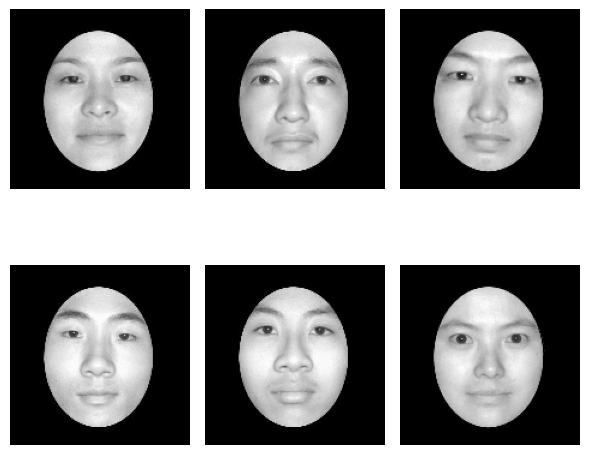

In [68]:
# Récupérer un lot d'images du générateur
batch = next(datatest_east_asian)

# Extraire les images et les étiquettes du lot
images = batch[0]
labels = batch[1]

num_rows = 2
num_cols = 3

plt.figure(figsize=(6, 6))
for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].reshape((150,150)), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Entrainement réseau & Récupération de la couche latente

In [96]:
ethnies = ['white', 'asian']
dict = {'white': [datatrain_white, datatest_white], 'asian': [datatrain_east_asian, datatest_east_asian]}

for ethnie in ethnies:
    model = create_resnet_autoencoder(input_latent=32)
    chekpoint_path = f'stim_autoencoder_{ethnie}_32.hdf5'
    checkpoint_callback = ModelCheckpoint(
        filepath=chekpoint_path,
        save_weights_only=False,
        save_frequency='epoch',
        save_best_only=True)
    
    model.fit(x=dict[ethnie][0], epochs=100000, batch_size=16, validation_data=dict[ethnie][1], verbose=0)
    get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)
    model.fit(x=dict[ethnie][0], epochs=1, batch_size=16, validation_data=dict[ethnie][1], callbacks=[checkpoint_callback]) #enregister le modèle
"""     latent_asian = get_latent.predict(datatrain_east_asian)
    latent_white = get_latent.predict(datatrain_white)

    asian_predict = model.predict(datatrain_east_asian).reshape(50,150,150)
    white_predict = model.predict(datatrain_white).reshape(50,150,150)
    asian = generator_to_array(datatrain_east_asian).reshape(50,150,150)
    white = generator_to_array(datatrain_white).reshape(50,150,150)

    asian_predict_flatten = asian_predict.reshape(50, -1)
    white_predict_flatten = white_predict.reshape(50, -1)
    asian_flatten = asian.reshape(50, -1)
    white_flatten = white.reshape(50, -1)

    distrib_white = tf.nn.softmax(latent_white, axis = 0)
    distrib_asian = tf.nn.softmax(latent_asian, axis = 0)

    ##----------------------------------------------Analyse Qualitative
    comparaison_visages(asian, asian_predict, white, white_predict, ethnie)
    latent_pca = pca(latent_asian, latent_white, ethnie)
    k_means(latent_pca)
    cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten)
    comparaison_dispersion(latent_asian, latent_white) """


4/4 [==============================] - 1s 154ms/step - loss: 0.0020 - mae: 0.0202 - val_loss: 0.0029 - val_mae: 0.0258


'     latent_asian = get_latent.predict(datatrain_east_asian)\n    latent_white = get_latent.predict(datatrain_white)\n\n    asian_predict = model.predict(datatrain_east_asian).reshape(50,150,150)\n    white_predict = model.predict(datatrain_white).reshape(50,150,150)\n    asian = generator_to_array(datatrain_east_asian).reshape(50,150,150)\n    white = generator_to_array(datatrain_white).reshape(50,150,150)\n\n    asian_predict_flatten = asian_predict.reshape(50, -1)\n    white_predict_flatten = white_predict.reshape(50, -1)\n    asian_flatten = asian.reshape(50, -1)\n    white_flatten = white.reshape(50, -1)\n\n    distrib_white = tf.nn.softmax(latent_white, axis = 0)\n    distrib_asian = tf.nn.softmax(latent_asian, axis = 0)\n\n    ##----------------------------------------------Analyse Qualitative\n    comparaison_visages(asian, asian_predict, white, white_predict, ethnie)\n    latent_pca = pca(latent_asian, latent_white, ethnie)\n    k_means(latent_pca)\n    cosinus_similarity(asi

In [95]:
A = np.ones(shape=(150,150))
B = np.zeros(shape=(150, 150))
mse(A,B)

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

In [92]:
def mse(ytrue, ypred):
    return tf.reduce_mean(tf.square((ytrue-ypred)))

In [93]:
mse(asian, asian_predict)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0059332466>

In [94]:
mse(white, white_predict)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0088177435>

In [35]:
mean_latent_asian = np.mean(latent_asian, axis=0)
mean_latent_white = np.mean(latent_white, axis=0)

In [40]:
mean_latent_asian

array([ 0.00180455, -0.10137898,  0.00384349, -0.09648237, -0.10303987,
        0.01086095, -0.09449203, -0.01143513, -0.06584331, -0.12898345,
       -0.0286456 , -0.08866829, -0.03976572, -0.07901037, -0.12559958,
       -0.00320686, -0.00482777, -0.00825972,  0.0012951 ,  0.00348378,
        0.00416091,  0.00258129, -0.0553588 ,  0.01166931, -0.01493721,
       -0.13476183,  0.01913404,  0.03081325, -0.00569345, -0.08050159,
       -0.09552553,  0.02181722], dtype=float32)

In [47]:
mean_latent_white

array([ 0.00180455, -0.36813474,  0.00384349, -1.0832169 , -0.85318   ,
        0.01086095, -0.99888694,  0.46166506, -0.5260039 , -1.2826438 ,
       -0.7019657 , -0.74506265, -0.7884298 , -0.53688425, -1.0063944 ,
       -0.00320686, -0.00482777, -0.00825972,  0.39474928,  0.32420376,
        0.00416091,  0.00258129, -0.86370003,  0.02382813,  0.43706033,
       -1.294275  ,  0.44599712,  0.03773176, -0.00569345, -0.48849857,
       -1.2308576 , -0.3553771 ], dtype=float32)

In [42]:
mask = mean_latent_white == mean_latent_asian

In [49]:
mask.count()

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [37]:
distrib_white = tf.nn.softmax(mean_latent_white)
distrib_asian = tf.nn.softmax(mean_latent_asian)

In [44]:
normalize_a = tf.nn.l2_normalize(mean_latent_white,axis=0)        
normalize_b = tf.nn.l2_normalize(mean_latent_asian,axis=0)
cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))

In [45]:
cos_similarity

<tf.Tensor: shape=(), dtype=float32, numpy=0.89974403>

In [54]:
normalize_a = tf.nn.l2_normalize(distrib_white,axis=0)        
normalize_b = tf.nn.l2_normalize(distrib_asian,axis=0)
cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
np.array(cos_similarity)

array(0.9126676, dtype=float32)

In [56]:
print(f"coeff de bahattacharyya = {np.array(cos_similarity)}")

coeff de bahattacharyya = 0.9126675724983215


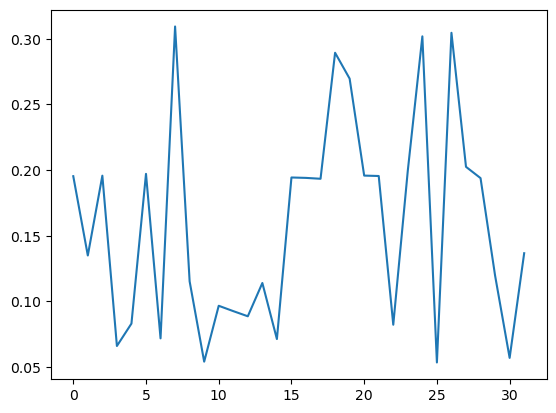

In [58]:
plt.plot(normalize_a)

1/1 [==============================] - 0s 28ms/step


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3940: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'


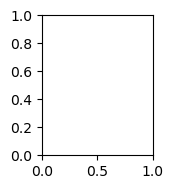

In [75]:
test_asian = generator_to_array(datatest_east_asian)
test_asian_predict = model.predict(test_asian)
test_white = generator_to_array(datatest_white)
test_white_predict = model.predict(test_white)

num_images = 6
plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Afficher l'image originale
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(cv2.resize(test_white[i],(300, 300), interpolation=cv2.INTER_LINEAR), cmap='gray')
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(cv2.resize(test_white_predict[i], (300, 300), interpolation=cv2.INTER_LINEAR), cmap='gray')
    plt.title("Reconstruction")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [74]:
import cv2

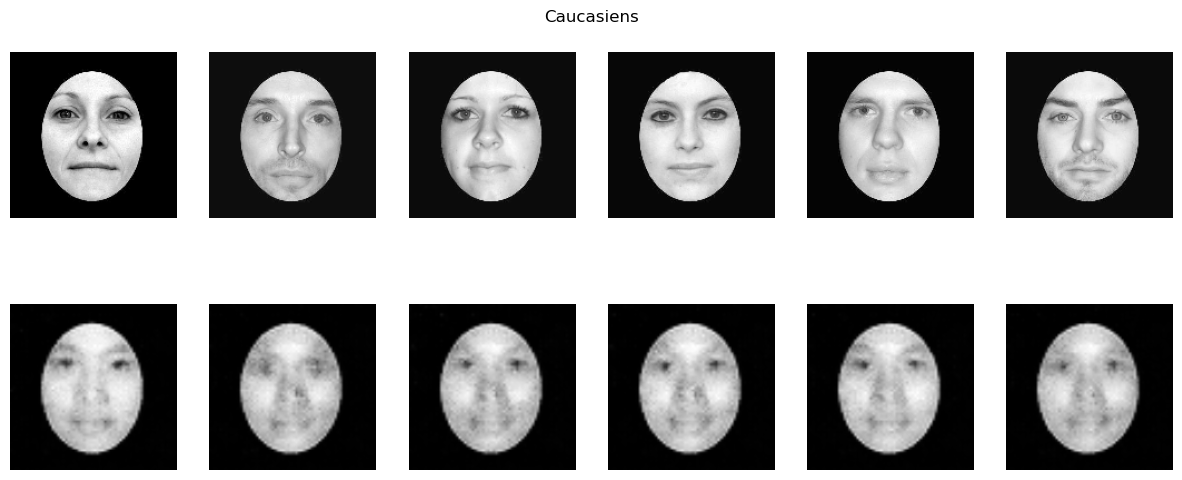

In [82]:
plt.figure(figsize=(15, 6)) 

# Affichage des images du premier datatrain
plt.subplot(2, 6, (1, 6))
plt.axis('off')
plt.title('Caucasiens')
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.axis('off')
    plt.imshow(test_white[i], cmap='gray')
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(test_white_predict[i], cmap='gray')
    plt.axis('off')